# (30) Revsions -- Membership tier (collapse)

**Motivation**: Nat. Comm. revision work. Collapse blue/orange for membership tier fig. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(tmp_dir, '_Ca-fMRI-Feb11'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = pjoin(fig_base_dir, 'rebuttal')
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

## Prepare (512)

In [3]:
mice = Mice(nn)

## Results (K = 7)

In [4]:
%%time

num_k = 7
mu_vals = [
    np.round(e / num_k, 3)
    for e in [0.5, 1, 1.75, 3.5]
]
results = member_results(
    mice=mice,
    num_k=num_k,
    use_prune=True,
    merge_thres=0.444,
    n_resamples=int(1e5),
    mu_vals=mu_vals,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 24.1 s, sys: 1min 18s, total: 1min 42s
Wall time: 2min 29s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'mu_vals',
    'members',
    'reject',
    'scores'
]

## Plot results

In [5]:
from figures.fig_mem import mk_member_cmap
spectral, accent = mk_member_cmap(acc=[1, 3, 5])

### Num parent networks (nodewise)

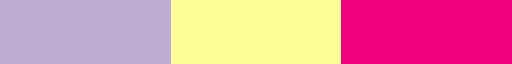

In [6]:
accent

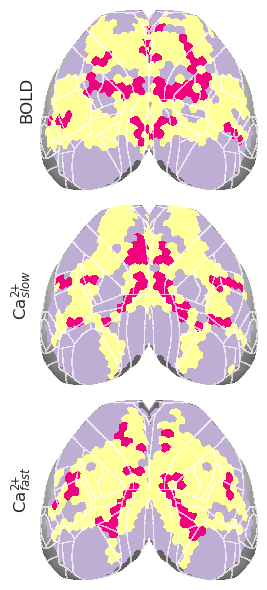

In [7]:
mu = np.round(1 / num_k, 3)

_ = bt.show(
    data={
        mode: d1[mu]['node_mem'] for
        mode, d1 in results['scores'].items()},
    vmin=1,
    vmax=4,
    cmap=accent,
    interp='none',
    mask_thresh=0.01,
    contour_coarse=False,
    contour_cmap='Greys',
    contour_alpha=0.7,
    figsize=(3, 6),
    dpi=100,
)

### Bar plot

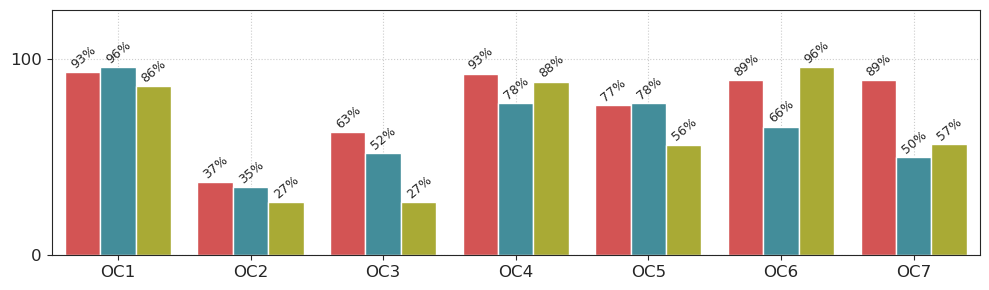

In [8]:
from figures.fig_mem import scores_bar as go
fig, _ = go(results, mu=mu)

### Pie

In [9]:
mode2lbl = {
    BOLD: 'BOLD',
    CAS: 'CAS',
    CAF: 'CAF',
}

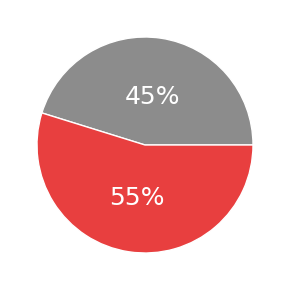

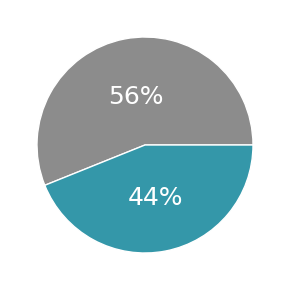

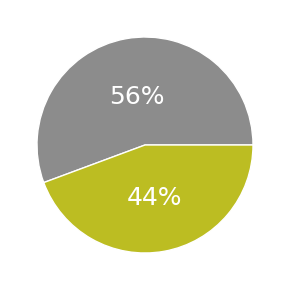

In [10]:
from figures.fig_mem import scores_pie as go
figs = go(results, mu=mu, radius={
    BOLD: (0.45, 0.5),
    CAS: (0.45, 0.5),
    CAF: (0.45, 0.5),
})
[
    display(f) for f
    in figs.values()
];

### Tiers on cortex

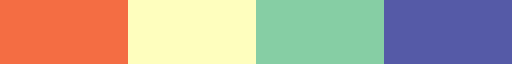

In [11]:
spectral

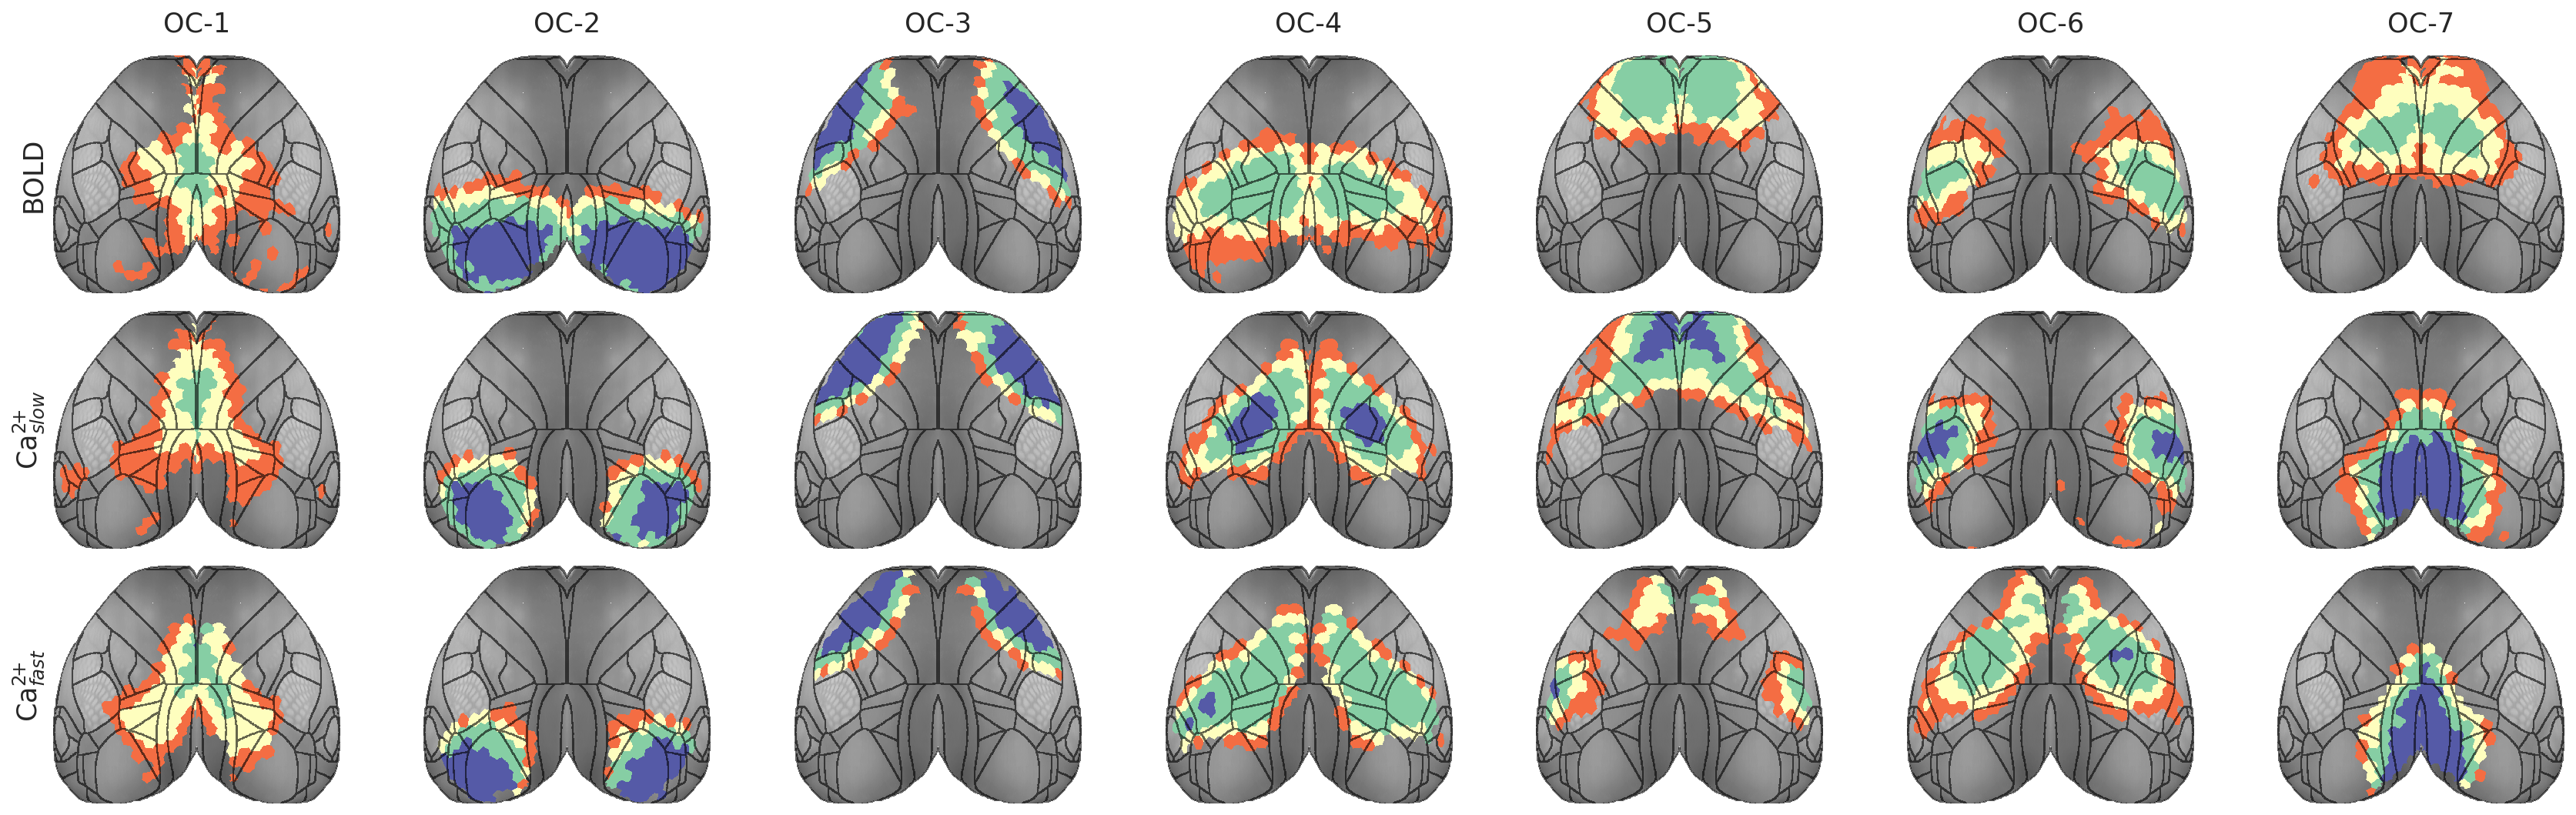

In [12]:
kws_show = {
    'vmin': 1,
    'vmax': len(results['mu_vals']),
    'interp': 'none',
    'cmap': spectral,
    'mask_thresh': 0.001,
    'contour_width': 0.2,
    'contour_alpha': 0.6,
    'contour_cmap': 'Greys_r',
    'contour_coarse': False,
    'add_disjoint': False,
    'add_title': True,
}
_ = bt.show(results['members'], dpi=150, **kws_show)

## Now do the collapse (new)

In [13]:
collapsed = {
    k: np.zeros((4, len(bt.n2l)))
    for k in results['members']
}
for k, x in results['members'].items():
    vals = list(unique_idxs(x))
    for i, v in enumerate(vals):
        a = x.copy()
        a[a != v] = 0.0
        a = a.sum(0) > 0
        a = a.astype(float) * v
        collapsed[k][i] = a 

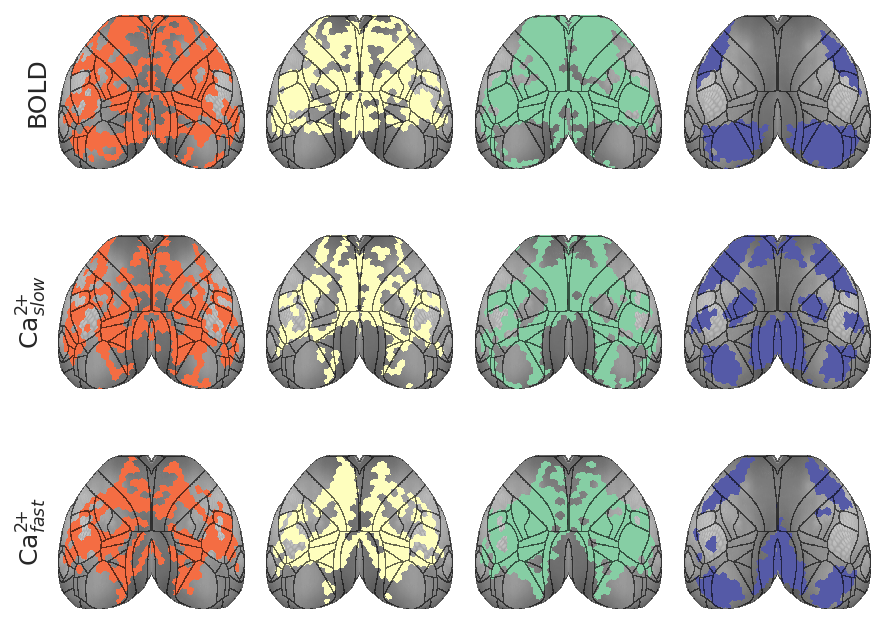

In [67]:
kws_show = {
    'vmin': 1,
    'vmax': len(results['mu_vals']),
    'interp': 'none',
    'cmap': spectral,
    'mask_thresh': 0.001,
    'contour_width': 0.2,
    'contour_alpha': 0.6,
    'contour_cmap': 'Greys_r',
    'contour_coarse': False,
    'add_disjoint': False,
    'add_title': False,
    'dpi': 150,
    'figsize_x': 2.0,
    'figsize_y': 1.6, 
}
fig, _ = bt.show(collapsed, **kws_show)

In [68]:
kws_fig['transparent'] = False
fig.savefig(pjoin(fig_dir, 'mem_collapsed.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'mem_collapsed.pdf'), **kws_fig)

## Quantify fraction of pixels

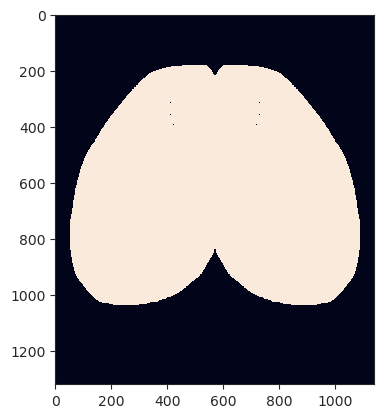

In [38]:
top, _ = bt.load_top_flat()
top = top.astype(bool)
plt.imshow(top);

In [42]:
tiers = ['Orange', 'Yellow', 'Green', 'Purple']

In [58]:
from IPython.display import display, Latex

In [60]:
for k, v in collapsed.items():
    x = bt.project_vec(v)['top'].astype(bool)
    x = np.sum(x, axis=(1, 2))
    x = x / top.sum()
    
    c = k.replace('\\!\\!', '')
    val = ', '.join([
        f"{tiers[i]}: {e:0.3f}"
        for i, e in enumerate(x)
    ])
    msg = ','.join([
        f"{c}",
        f"$\quad$ pixel ratio = [{val}]",
    ])
    display(Latex(msg))

## Cos sim of collapsed

In [300]:
list(collapsed)

['BOLD', 'Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$']

In [301]:
collapsed[BOLD].shape

(4, 542)

In [302]:
mode2lbl = {BOLD: 'BOLD', CAS: 'CAS', CAF: 'CAF'}

In [303]:
d2p = []

pairs = list(itertools.product(
    collapsed, range(4)))
dice = np.zeros((
    len(collapsed) * 4,
    len(collapsed) * 4,
))
for (i, (k1, i1)), (j, (k2, i2)) in itertools.combinations(enumerate(pairs), 2):
    x1, x2 = collapsed[k1][i1], collapsed[k2][i2]
    dice[i, j] = dice_score(x1 > 0, x2 > 0)
    d2p.append({
        'cond_mode': ['within' if k1 == k2 else 'across'],
        'cond_tier': ['within' if i1 == i2 else 'across'],
        'k1': [mode2lbl[k1]],
        'k2': [mode2lbl[k2]],
        'i1': [i1],
        'i2': [i2],
        'd': [dice[i, j]],
    })
d2p = pd.DataFrame(merge_dicts(d2p))

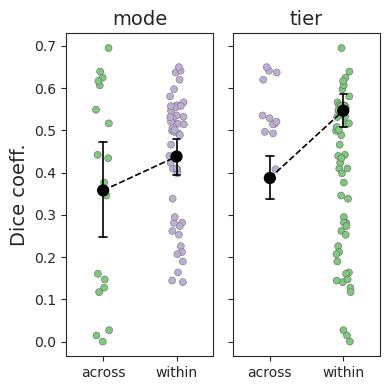

In [304]:
fig, axes = create_figure(1, 2, (4, 4), 'all', 'all', constrained_layout=True)
for i, cond in enumerate(['cond_mode', 'cond_tier']):
    sns.stripplot(
        data=d2p,
        x=cond,
        y='d',
        hue=cond,
        palette='Accent',
        linewidth=0.4,
        size=5,
        zorder=0,
        ax=axes[i],
    )
    sns.pointplot(
        data=d2p,
        x=cond,
        y='d',
        color='k',
        join=True,
        linestyles='--',
        # errwidth=1,
        capsize=0.1,
        ax=axes[i],
    )
    axes[i].legend().remove()
    axes[i].set_title(cond.split('_')[1], fontsize=14)
    axes[i].set(xlabel='', ylabel='')
    for line in axes[i].lines:
        line.set_linewidth(1.2)

# sns.move_legend(axes[1], 'best', fontsize=11, title='')
axes[0].set_ylabel('Dice coeff.', fontsize=14)
fig.savefig(pjoin(fig_dir, 'dice_stripplot.pdf'), bbox_inches='tight')
plt.show()

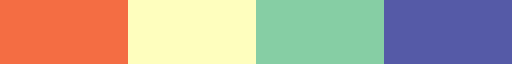

In [305]:
spectral

In [306]:
spectral.colors

[
    (0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0),
    (0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0),
    (0.5273356401384084, 0.8106113033448674, 0.6452133794694349, 1.0),
    (0.3347943098808151, 0.35363321799307956, 0.6560553633217993, 1.0)
]

In [307]:
ticklabels = [f"{mode2lbl[k]}-({i})" for (k, i) in pairs]

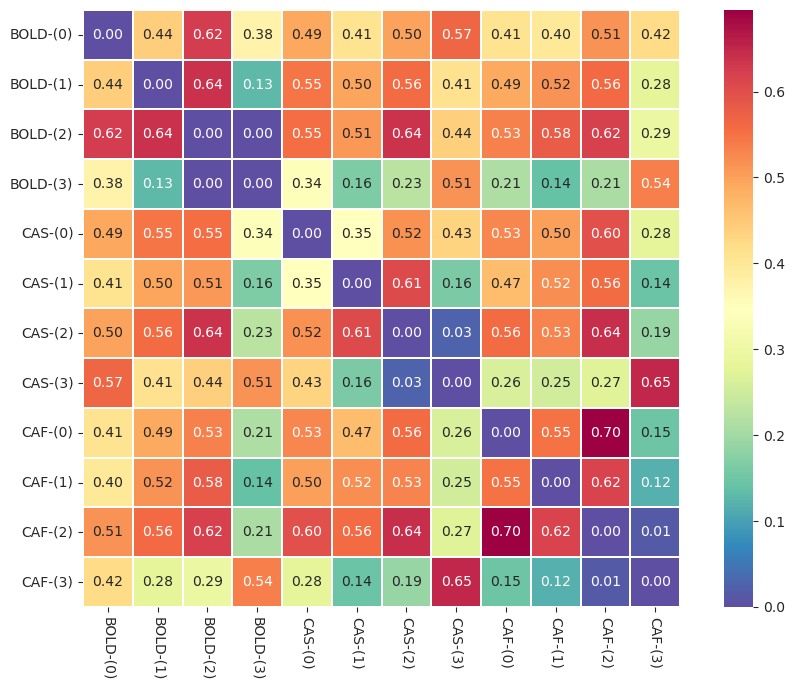

In [308]:
fig, ax = create_figure(1, 1, (9, 7))
sns.heatmap(
    dice + dice.T,
    cmap='Spectral_r',
    linewidths=0.04,
    square=True,
    annot=True,
    fmt='0.2f',
    ax=ax,
)
#im = ax.imshow(dice + dice.T, cmap='Spectral_r')
#ax.locator_params(axis='both', nbins=13)
ax.set(
    xticks=[e + 0.5 for e in range(len(ticklabels))],
    yticks=[e + 0.5 for e in range(len(ticklabels))],
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
ax.tick_params(axis='x',  rotation=-90)
ax.tick_params(axis='y',  rotation=0)
# plt.colorbar(im, ax=ax)
fig.savefig(pjoin(fig_dir, 'dice_heatmap.pdf'), bbox_inches='tight')
plt.show()